In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 0")
    device_num = 0
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

num_folds = 3

num_classes = 3

num_workers_tr = 1
batch_size_tr = 32
num_workers_vl = 1
batch_size_vl = 4

num_slices = 32
size_x = 160
size_y = 320


model_filename_base = "./results/BAMC_PTX_3DUNet-Middle-Extruded-NS.best_model.vfold.UNETR.adam.1e-4"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Device number assumed to be 0
Num images / labels = 62 62


In [3]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

4 4 6
4 6 4
6 4 4


../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz
../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.extruded-overlay-NS.nii.gz


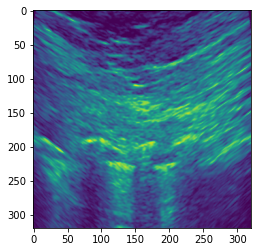

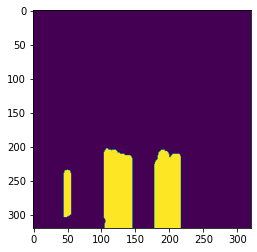

In [4]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['trilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|███████████████████████████| 4/4 [00:05<00:00,  1.40s/it]


torch.Size([4, 1, 160, 320, 32])
torch.Size([160, 320, 32])
image shape: torch.Size([160, 320, 32]), label shape: torch.Size([160, 320, 32])


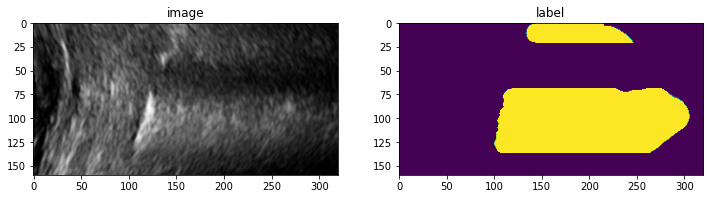

tensor(0.) tensor(2.)


In [7]:
imgnum = 2
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum][0], check_data["label"][imgnum][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))

max_epochs = 500
net_channels=(32, 64, 128)
net_strides=(2, 2)

In [9]:
from monai.networks.nets import UNETR
# model = UNETR(1, 
#               num_classes, 
#               image.shape, 
#               feature_size=16, 
#               hidden_size=768, 
#               mlp_dim=3072, 
#               num_heads=12, 
#               pos_embed='conv', 
#               norm_name='instance', 
#               conv_block=True, 
#               res_block=True, 
#               dropout_rate=0.0, 
#               spatial_dims=3).to(device)

In [10]:
# model(check_data['image'].to(device))
# model
# check_data['image']

import gc
gc.collect()
torch.cuda.empty_cache()



In [11]:
device=1
def vfold_train(vfold_num, train_loader, val_loader):
#     model = UNet(
#         dimensions=3,
#         in_channels=1,
#         out_channels=num_classes,
#         channels=net_channels,
#         strides=net_strides,
#         num_res_units=2,
#         norm=Norm.BATCH,
#     ).to(device)
    
    model = UNETR(1, 
              num_classes, 
              image.shape, 
              feature_size=16, 
              hidden_size=768, 
              mlp_dim=3072, 
              num_heads=12, 
              pos_embed='conv', 
              norm_name='instance', 
              conv_block=True, 
              res_block=True, 
              dropout_rate=0.0, 
              spatial_dims=3).to(device)
    
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), model_filename_base+'_'+str(vfold_num)+'.pth')
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [12]:
for i in range(device_num,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/500
1/0, train_loss: 0.7591
0 epoch 1 average loss: 0.7591
----------
0: epoch 2/500
1/0, train_loss: 0.7524
0 epoch 2 average loss: 0.7524
saved new best metric model
current epoch: 2 current mean dice: 0.3267
best mean dice: 0.3267 at epoch: 2
----------
0: epoch 3/500
1/0, train_loss: 0.7471
0 epoch 3 average loss: 0.7471
----------
0: epoch 4/500
1/0, train_loss: 0.7411
0 epoch 4 average loss: 0.7411
saved new best metric model
current epoch: 4 current mean dice: 0.3427
best mean dice: 0.3427 at epoch: 4
----------
0: epoch 5/500
1/0, train_loss: 0.7369
0 epoch 5 average loss: 0.7369
----------
0: epoch 6/500
1/0, train_loss: 0.7330
0 epoch 6 average loss: 0.7330
saved new best metric model
current epoch: 6 current mean dice: 0.3518
best mean dice: 0.3518 at epoch: 6
----------
0: epoch 7/500
1/0, train_loss: 0.7293
0 epoch 7 average loss: 0.7293
----------
0: epoch 8/500
1/0, train_loss: 0.7266
0 epoch 8 average loss: 0.7266
saved new best metric model
curren

current epoch: 64 current mean dice: 0.4006
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 65/500
1/0, train_loss: 0.6032
0 epoch 65 average loss: 0.6032
----------
0: epoch 66/500
1/0, train_loss: 0.6034
0 epoch 66 average loss: 0.6034
current epoch: 66 current mean dice: 0.4020
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 67/500
1/0, train_loss: 0.5996
0 epoch 67 average loss: 0.5996
----------
0: epoch 68/500
1/0, train_loss: 0.6003
0 epoch 68 average loss: 0.6003
current epoch: 68 current mean dice: 0.4133
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 69/500
1/0, train_loss: 0.5968
0 epoch 69 average loss: 0.5968
----------
0: epoch 70/500
1/0, train_loss: 0.5970
0 epoch 70 average loss: 0.5970
current epoch: 70 current mean dice: 0.3998
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 71/500
1/0, train_loss: 0.5941
0 epoch 71 average loss: 0.5941
----------
0: epoch 72/500
1/0, train_loss: 0.5945
0 epoch 72 average loss: 0.5945
current epoch: 7

current epoch: 130 current mean dice: 0.2862
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 131/500
1/0, train_loss: 0.5409
0 epoch 131 average loss: 0.5409
----------
0: epoch 132/500
1/0, train_loss: 0.5423
0 epoch 132 average loss: 0.5423
current epoch: 132 current mean dice: 0.3139
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 133/500
1/0, train_loss: 0.5362
0 epoch 133 average loss: 0.5362
----------
0: epoch 134/500
1/0, train_loss: 0.5411
0 epoch 134 average loss: 0.5411
current epoch: 134 current mean dice: 0.3242
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 135/500
1/0, train_loss: 0.5324
0 epoch 135 average loss: 0.5324
----------
0: epoch 136/500
1/0, train_loss: 0.5386
0 epoch 136 average loss: 0.5386
current epoch: 136 current mean dice: 0.3456
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 137/500
1/0, train_loss: 0.5288
0 epoch 137 average loss: 0.5288
----------
0: epoch 138/500
1/0, train_loss: 0.5286
0 epoch 138 average loss: 0.5

1/0, train_loss: 0.5074
0 epoch 196 average loss: 0.5074
current epoch: 196 current mean dice: 0.2436
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 197/500
1/0, train_loss: 0.5110
0 epoch 197 average loss: 0.5110
----------
0: epoch 198/500
1/0, train_loss: 0.5145
0 epoch 198 average loss: 0.5145
current epoch: 198 current mean dice: 0.2361
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 199/500
1/0, train_loss: 0.5051
0 epoch 199 average loss: 0.5051
----------
0: epoch 200/500
1/0, train_loss: 0.5035
0 epoch 200 average loss: 0.5035
current epoch: 200 current mean dice: 0.2377
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 201/500
1/0, train_loss: 0.5061
0 epoch 201 average loss: 0.5061
----------
0: epoch 202/500
1/0, train_loss: 0.5032
0 epoch 202 average loss: 0.5032
current epoch: 202 current mean dice: 0.3256
best mean dice: 0.4199 at epoch: 54
----------
0: epoch 203/500
1/0, train_loss: 0.5147
0 epoch 203 average loss: 0.5147
----------
0: epoch 204/

1/0, train_loss: 0.4895
0 epoch 261 average loss: 0.4895
----------
0: epoch 262/500
1/0, train_loss: 0.4859
0 epoch 262 average loss: 0.4859
current epoch: 262 current mean dice: 0.2406
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 263/500
1/0, train_loss: 0.4860
0 epoch 263 average loss: 0.4860
----------
0: epoch 264/500
1/0, train_loss: 0.4870
0 epoch 264 average loss: 0.4870
current epoch: 264 current mean dice: 0.2581
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 265/500
1/0, train_loss: 0.4883
0 epoch 265 average loss: 0.4883
----------
0: epoch 266/500
1/0, train_loss: 0.4998
0 epoch 266 average loss: 0.4998
current epoch: 266 current mean dice: 0.2432
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 267/500
1/0, train_loss: 0.4869
0 epoch 267 average loss: 0.4869
----------
0: epoch 268/500
1/0, train_loss: 0.4902
0 epoch 268 average loss: 0.4902
current epoch: 268 current mean dice: 0.2861
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 

current epoch: 326 current mean dice: 0.2225
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 327/500
1/0, train_loss: 0.4741
0 epoch 327 average loss: 0.4741
----------
0: epoch 328/500
1/0, train_loss: 0.4694
0 epoch 328 average loss: 0.4694
current epoch: 328 current mean dice: 0.2377
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 329/500
1/0, train_loss: 0.4709
0 epoch 329 average loss: 0.4709
----------
0: epoch 330/500
1/0, train_loss: 0.4812
0 epoch 330 average loss: 0.4812
current epoch: 330 current mean dice: 0.2301
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 331/500
1/0, train_loss: 0.4748
0 epoch 331 average loss: 0.4748
----------
0: epoch 332/500
1/0, train_loss: 0.4716
0 epoch 332 average loss: 0.4716
current epoch: 332 current mean dice: 0.2410
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 333/500
1/0, train_loss: 0.4698
0 epoch 333 average loss: 0.4698
----------
0: epoch 334/500
1/0, train_loss: 0.4711
0 epoch 334 average loss:

1/0, train_loss: 0.4597
0 epoch 392 average loss: 0.4597
current epoch: 392 current mean dice: 0.2269
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 393/500
1/0, train_loss: 0.4578
0 epoch 393 average loss: 0.4578
----------
0: epoch 394/500
1/0, train_loss: 0.4564
0 epoch 394 average loss: 0.4564
current epoch: 394 current mean dice: 0.2291
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 395/500
1/0, train_loss: 0.4612
0 epoch 395 average loss: 0.4612
----------
0: epoch 396/500
1/0, train_loss: 0.4622
0 epoch 396 average loss: 0.4622
current epoch: 396 current mean dice: 0.2294
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 397/500
1/0, train_loss: 0.4575
0 epoch 397 average loss: 0.4575
----------
0: epoch 398/500
1/0, train_loss: 0.4547
0 epoch 398 average loss: 0.4547
current epoch: 398 current mean dice: 0.2410
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 399/500
1/0, train_loss: 0.4596
0 epoch 399 average loss: 0.4596
----------
0: epoch 

1/0, train_loss: 0.4469
0 epoch 457 average loss: 0.4469
----------
0: epoch 458/500
1/0, train_loss: 0.4465
0 epoch 458 average loss: 0.4465
current epoch: 458 current mean dice: 0.2113
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 459/500
1/0, train_loss: 0.4487
0 epoch 459 average loss: 0.4487
----------
0: epoch 460/500
1/0, train_loss: 0.4466
0 epoch 460 average loss: 0.4466
current epoch: 460 current mean dice: 0.2139
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 461/500
1/0, train_loss: 0.4493
0 epoch 461 average loss: 0.4493
----------
0: epoch 462/500
1/0, train_loss: 0.4478
0 epoch 462 average loss: 0.4478
current epoch: 462 current mean dice: 0.2204
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 463/500
1/0, train_loss: 0.4520
0 epoch 463 average loss: 0.4520
----------
0: epoch 464/500
1/0, train_loss: 0.4457
0 epoch 464 average loss: 0.4457
current epoch: 464 current mean dice: 0.2247
best mean dice: 0.4238 at epoch: 216
----------
0: epoch 

1/0, train_loss: 0.6793
1 epoch 21 average loss: 0.6793
----------
1: epoch 22/500
1/0, train_loss: 0.6776
1 epoch 22 average loss: 0.6776
saved new best metric model
current epoch: 22 current mean dice: 0.4531
best mean dice: 0.4531 at epoch: 22
----------
1: epoch 23/500
1/0, train_loss: 0.6751
1 epoch 23 average loss: 0.6751
----------
1: epoch 24/500
1/0, train_loss: 0.6756
1 epoch 24 average loss: 0.6756
saved new best metric model
current epoch: 24 current mean dice: 0.4555
best mean dice: 0.4555 at epoch: 24
----------
1: epoch 25/500
1/0, train_loss: 0.6752
1 epoch 25 average loss: 0.6752
----------
1: epoch 26/500
1/0, train_loss: 0.6739
1 epoch 26 average loss: 0.6739
saved new best metric model
current epoch: 26 current mean dice: 0.4584
best mean dice: 0.4584 at epoch: 26
----------
1: epoch 27/500
1/0, train_loss: 0.6690
1 epoch 27 average loss: 0.6690
----------
1: epoch 28/500
1/0, train_loss: 0.6672
1 epoch 28 average loss: 0.6672
saved new best metric model
current epo

1/0, train_loss: 0.6002
1 epoch 84 average loss: 0.6002
current epoch: 84 current mean dice: 0.5114
best mean dice: 0.5393 at epoch: 78
----------
1: epoch 85/500
1/0, train_loss: 0.6011
1 epoch 85 average loss: 0.6011
----------
1: epoch 86/500
1/0, train_loss: 0.6045
1 epoch 86 average loss: 0.6045
current epoch: 86 current mean dice: 0.5246
best mean dice: 0.5393 at epoch: 78
----------
1: epoch 87/500
1/0, train_loss: 0.5962
1 epoch 87 average loss: 0.5962
----------
1: epoch 88/500
1/0, train_loss: 0.5950
1 epoch 88 average loss: 0.5950
current epoch: 88 current mean dice: 0.5292
best mean dice: 0.5393 at epoch: 78
----------
1: epoch 89/500
1/0, train_loss: 0.5974
1 epoch 89 average loss: 0.5974
----------
1: epoch 90/500
1/0, train_loss: 0.5924
1 epoch 90 average loss: 0.5924
saved new best metric model
current epoch: 90 current mean dice: 0.5466
best mean dice: 0.5466 at epoch: 90
----------
1: epoch 91/500
1/0, train_loss: 0.5920
1 epoch 91 average loss: 0.5920
----------
1: e

1/0, train_loss: 0.5500
1 epoch 148 average loss: 0.5500
current epoch: 148 current mean dice: 0.6097
best mean dice: 0.6442 at epoch: 142
----------
1: epoch 149/500
1/0, train_loss: 0.5597
1 epoch 149 average loss: 0.5597
----------
1: epoch 150/500
1/0, train_loss: 0.5462
1 epoch 150 average loss: 0.5462
current epoch: 150 current mean dice: 0.5345
best mean dice: 0.6442 at epoch: 142
----------
1: epoch 151/500
1/0, train_loss: 0.5571
1 epoch 151 average loss: 0.5571
----------
1: epoch 152/500
1/0, train_loss: 0.5513
1 epoch 152 average loss: 0.5513
saved new best metric model
current epoch: 152 current mean dice: 0.6497
best mean dice: 0.6497 at epoch: 152
----------
1: epoch 153/500
1/0, train_loss: 0.5464
1 epoch 153 average loss: 0.5464
----------
1: epoch 154/500
1/0, train_loss: 0.5448
1 epoch 154 average loss: 0.5448
current epoch: 154 current mean dice: 0.5849
best mean dice: 0.6497 at epoch: 152
----------
1: epoch 155/500
1/0, train_loss: 0.5416
1 epoch 155 average loss:

current epoch: 212 current mean dice: 0.6435
best mean dice: 0.6628 at epoch: 198
----------
1: epoch 213/500
1/0, train_loss: 0.5048
1 epoch 213 average loss: 0.5048
----------
1: epoch 214/500
1/0, train_loss: 0.5087
1 epoch 214 average loss: 0.5087
current epoch: 214 current mean dice: 0.6563
best mean dice: 0.6628 at epoch: 198
----------
1: epoch 215/500
1/0, train_loss: 0.5038
1 epoch 215 average loss: 0.5038
----------
1: epoch 216/500
1/0, train_loss: 0.5033
1 epoch 216 average loss: 0.5033
current epoch: 216 current mean dice: 0.6462
best mean dice: 0.6628 at epoch: 198
----------
1: epoch 217/500
1/0, train_loss: 0.5067
1 epoch 217 average loss: 0.5067
----------
1: epoch 218/500
1/0, train_loss: 0.5012
1 epoch 218 average loss: 0.5012
current epoch: 218 current mean dice: 0.6476
best mean dice: 0.6628 at epoch: 198
----------
1: epoch 219/500
1/0, train_loss: 0.5037
1 epoch 219 average loss: 0.5037
----------
1: epoch 220/500
1/0, train_loss: 0.5039
1 epoch 220 average loss:

1/0, train_loss: 0.4797
1 epoch 277 average loss: 0.4797
----------
1: epoch 278/500
1/0, train_loss: 0.4736
1 epoch 278 average loss: 0.4736
current epoch: 278 current mean dice: 0.6980
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 279/500
1/0, train_loss: 0.4753
1 epoch 279 average loss: 0.4753
----------
1: epoch 280/500
1/0, train_loss: 0.4787
1 epoch 280 average loss: 0.4787
current epoch: 280 current mean dice: 0.6882
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 281/500
1/0, train_loss: 0.4770
1 epoch 281 average loss: 0.4770
----------
1: epoch 282/500
1/0, train_loss: 0.4753
1 epoch 282 average loss: 0.4753
current epoch: 282 current mean dice: 0.6636
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 283/500
1/0, train_loss: 0.4806
1 epoch 283 average loss: 0.4806
----------
1: epoch 284/500
1/0, train_loss: 0.4739
1 epoch 284 average loss: 0.4739
current epoch: 284 current mean dice: 0.6798
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 

current epoch: 342 current mean dice: 0.6665
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 343/500
1/0, train_loss: 0.4552
1 epoch 343 average loss: 0.4552
----------
1: epoch 344/500
1/0, train_loss: 0.4543
1 epoch 344 average loss: 0.4543
current epoch: 344 current mean dice: 0.6764
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 345/500
1/0, train_loss: 0.4538
1 epoch 345 average loss: 0.4538
----------
1: epoch 346/500
1/0, train_loss: 0.4542
1 epoch 346 average loss: 0.4542
current epoch: 346 current mean dice: 0.6854
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 347/500
1/0, train_loss: 0.4556
1 epoch 347 average loss: 0.4556
----------
1: epoch 348/500
1/0, train_loss: 0.4514
1 epoch 348 average loss: 0.4514
current epoch: 348 current mean dice: 0.6833
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 349/500
1/0, train_loss: 0.4536
1 epoch 349 average loss: 0.4536
----------
1: epoch 350/500
1/0, train_loss: 0.4519
1 epoch 350 average loss:

1/0, train_loss: 0.4433
1 epoch 408 average loss: 0.4433
current epoch: 408 current mean dice: 0.6659
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 409/500
1/0, train_loss: 0.4470
1 epoch 409 average loss: 0.4470
----------
1: epoch 410/500
1/0, train_loss: 0.4378
1 epoch 410 average loss: 0.4378
current epoch: 410 current mean dice: 0.6657
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 411/500
1/0, train_loss: 0.4430
1 epoch 411 average loss: 0.4430
----------
1: epoch 412/500
1/0, train_loss: 0.4433
1 epoch 412 average loss: 0.4433
current epoch: 412 current mean dice: 0.6664
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 413/500
1/0, train_loss: 0.4394
1 epoch 413 average loss: 0.4394
----------
1: epoch 414/500
1/0, train_loss: 0.4429
1 epoch 414 average loss: 0.4429
current epoch: 414 current mean dice: 0.6515
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 415/500
1/0, train_loss: 0.4430
1 epoch 415 average loss: 0.4430
----------
1: epoch 

1/0, train_loss: 0.4333
1 epoch 473 average loss: 0.4333
----------
1: epoch 474/500
1/0, train_loss: 0.4307
1 epoch 474 average loss: 0.4307
current epoch: 474 current mean dice: 0.6550
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 475/500
1/0, train_loss: 0.4312
1 epoch 475 average loss: 0.4312
----------
1: epoch 476/500
1/0, train_loss: 0.4267
1 epoch 476 average loss: 0.4267
current epoch: 476 current mean dice: 0.6763
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 477/500
1/0, train_loss: 0.4337
1 epoch 477 average loss: 0.4337
----------
1: epoch 478/500
1/0, train_loss: 0.4310
1 epoch 478 average loss: 0.4310
current epoch: 478 current mean dice: 0.6749
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 479/500
1/0, train_loss: 0.4308
1 epoch 479 average loss: 0.4308
----------
1: epoch 480/500
1/0, train_loss: 0.4258
1 epoch 480 average loss: 0.4258
current epoch: 480 current mean dice: 0.6692
best mean dice: 0.7051 at epoch: 248
----------
1: epoch 

1/0, train_loss: 0.6740
2 epoch 36 average loss: 0.6740
saved new best metric model
current epoch: 36 current mean dice: 0.2371
best mean dice: 0.2371 at epoch: 36
----------
2: epoch 37/500
1/0, train_loss: 0.6735
2 epoch 37 average loss: 0.6735
----------
2: epoch 38/500
1/0, train_loss: 0.6706
2 epoch 38 average loss: 0.6706
saved new best metric model
current epoch: 38 current mean dice: 0.2433
best mean dice: 0.2433 at epoch: 38
----------
2: epoch 39/500
1/0, train_loss: 0.6679
2 epoch 39 average loss: 0.6679
----------
2: epoch 40/500
1/0, train_loss: 0.6637
2 epoch 40 average loss: 0.6637
saved new best metric model
current epoch: 40 current mean dice: 0.2531
best mean dice: 0.2531 at epoch: 40
----------
2: epoch 41/500
1/0, train_loss: 0.6624
2 epoch 41 average loss: 0.6624
----------
2: epoch 42/500
1/0, train_loss: 0.6588
2 epoch 42 average loss: 0.6588
saved new best metric model
current epoch: 42 current mean dice: 0.2728
best mean dice: 0.2728 at epoch: 42
----------
2: 

1/0, train_loss: 0.5824
2 epoch 100 average loss: 0.5824
current epoch: 100 current mean dice: 0.3389
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 101/500
1/0, train_loss: 0.5822
2 epoch 101 average loss: 0.5822
----------
2: epoch 102/500
1/0, train_loss: 0.5793
2 epoch 102 average loss: 0.5793
current epoch: 102 current mean dice: 0.3477
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 103/500
1/0, train_loss: 0.5863
2 epoch 103 average loss: 0.5863
----------
2: epoch 104/500
1/0, train_loss: 0.5770
2 epoch 104 average loss: 0.5770
current epoch: 104 current mean dice: 0.2972
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 105/500
1/0, train_loss: 0.5782
2 epoch 105 average loss: 0.5782
----------
2: epoch 106/500
1/0, train_loss: 0.5809
2 epoch 106 average loss: 0.5809
current epoch: 106 current mean dice: 0.3307
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 107/500
1/0, train_loss: 0.5785
2 epoch 107 average loss: 0.5785
----------
2: epoch 108/

1/0, train_loss: 0.5333
2 epoch 165 average loss: 0.5333
----------
2: epoch 166/500
1/0, train_loss: 0.5316
2 epoch 166 average loss: 0.5316
current epoch: 166 current mean dice: 0.1605
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 167/500
1/0, train_loss: 0.5370
2 epoch 167 average loss: 0.5370
----------
2: epoch 168/500
1/0, train_loss: 0.5306
2 epoch 168 average loss: 0.5306
current epoch: 168 current mean dice: 0.1338
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 169/500
1/0, train_loss: 0.5347
2 epoch 169 average loss: 0.5347
----------
2: epoch 170/500
1/0, train_loss: 0.5314
2 epoch 170 average loss: 0.5314
current epoch: 170 current mean dice: 0.1742
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 171/500
1/0, train_loss: 0.5360
2 epoch 171 average loss: 0.5360
----------
2: epoch 172/500
1/0, train_loss: 0.5327
2 epoch 172 average loss: 0.5327
current epoch: 172 current mean dice: 0.1259
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 173/

1/0, train_loss: 0.4976
2 epoch 231 average loss: 0.4976
----------
2: epoch 232/500
1/0, train_loss: 0.5010
2 epoch 232 average loss: 0.5010
current epoch: 232 current mean dice: 0.1275
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 233/500
1/0, train_loss: 0.5042
2 epoch 233 average loss: 0.5042
----------
2: epoch 234/500
1/0, train_loss: 0.4993
2 epoch 234 average loss: 0.4993
current epoch: 234 current mean dice: 0.1239
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 235/500
1/0, train_loss: 0.5020
2 epoch 235 average loss: 0.5020
----------
2: epoch 236/500
1/0, train_loss: 0.5009
2 epoch 236 average loss: 0.5009
current epoch: 236 current mean dice: 0.1147
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 237/500
1/0, train_loss: 0.4979
2 epoch 237 average loss: 0.4979
----------
2: epoch 238/500
1/0, train_loss: 0.4989
2 epoch 238 average loss: 0.4989
current epoch: 238 current mean dice: 0.1227
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 239/

1/0, train_loss: 0.4781
2 epoch 297 average loss: 0.4781
----------
2: epoch 298/500
1/0, train_loss: 0.4768
2 epoch 298 average loss: 0.4768
current epoch: 298 current mean dice: 0.0774
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 299/500
1/0, train_loss: 0.4754
2 epoch 299 average loss: 0.4754
----------
2: epoch 300/500
1/0, train_loss: 0.4761
2 epoch 300 average loss: 0.4761
current epoch: 300 current mean dice: 0.0912
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 301/500
1/0, train_loss: 0.4753
2 epoch 301 average loss: 0.4753
----------
2: epoch 302/500
1/0, train_loss: 0.4767
2 epoch 302 average loss: 0.4767
current epoch: 302 current mean dice: 0.0665
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 303/500
1/0, train_loss: 0.4726
2 epoch 303 average loss: 0.4726
----------
2: epoch 304/500
1/0, train_loss: 0.4757
2 epoch 304 average loss: 0.4757
current epoch: 304 current mean dice: 0.0637
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 305/

1/0, train_loss: 0.4588
2 epoch 363 average loss: 0.4588
----------
2: epoch 364/500
1/0, train_loss: 0.4595
2 epoch 364 average loss: 0.4595
current epoch: 364 current mean dice: 0.0479
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 365/500
1/0, train_loss: 0.4598
2 epoch 365 average loss: 0.4598
----------
2: epoch 366/500
1/0, train_loss: 0.4587
2 epoch 366 average loss: 0.4587
current epoch: 366 current mean dice: 0.0584
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 367/500
1/0, train_loss: 0.4610
2 epoch 367 average loss: 0.4610
----------
2: epoch 368/500
1/0, train_loss: 0.4599
2 epoch 368 average loss: 0.4599
current epoch: 368 current mean dice: 0.0587
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 369/500
1/0, train_loss: 0.4578
2 epoch 369 average loss: 0.4578
----------
2: epoch 370/500
1/0, train_loss: 0.4582
2 epoch 370 average loss: 0.4582
current epoch: 370 current mean dice: 0.0506
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 371/

1/0, train_loss: 0.4439
2 epoch 429 average loss: 0.4439
----------
2: epoch 430/500
1/0, train_loss: 0.4441
2 epoch 430 average loss: 0.4441
current epoch: 430 current mean dice: 0.0582
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 431/500
1/0, train_loss: 0.4436
2 epoch 431 average loss: 0.4436
----------
2: epoch 432/500
1/0, train_loss: 0.4416
2 epoch 432 average loss: 0.4416
current epoch: 432 current mean dice: 0.0602
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 433/500
1/0, train_loss: 0.4435
2 epoch 433 average loss: 0.4435
----------
2: epoch 434/500
1/0, train_loss: 0.4458
2 epoch 434 average loss: 0.4458
current epoch: 434 current mean dice: 0.0530
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 435/500
1/0, train_loss: 0.4448
2 epoch 435 average loss: 0.4448
----------
2: epoch 436/500
1/0, train_loss: 0.4427
2 epoch 436 average loss: 0.4427
current epoch: 436 current mean dice: 0.0577
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 437/

1/0, train_loss: 0.4361
2 epoch 495 average loss: 0.4361
----------
2: epoch 496/500
1/0, train_loss: 0.4332
2 epoch 496 average loss: 0.4332
current epoch: 496 current mean dice: 0.0495
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 497/500
1/0, train_loss: 0.4349
2 epoch 497 average loss: 0.4349
----------
2: epoch 498/500
1/0, train_loss: 0.4365
2 epoch 498 average loss: 0.4365
current epoch: 498 current mean dice: 0.0645
best mean dice: 0.3660 at epoch: 88
----------
2: epoch 499/500
1/0, train_loss: 0.4352
2 epoch 499 average loss: 0.4352
----------
2: epoch 500/500
1/0, train_loss: 0.4336
2 epoch 500 average loss: 0.4336
current epoch: 500 current mean dice: 0.0426
best mean dice: 0.3660 at epoch: 88


In [14]:
device=1
def vfold_train(vfold_num, train_loader, val_loader):
#     model = UNet(
#         dimensions=3,
#         in_channels=1,
#         out_channels=num_classes,
#         channels=net_channels,
#         strides=net_strides,
#         num_res_units=2,
#         norm=Norm.BATCH,
#     ).to(device)
    
    model = UNETR(1, 
              num_classes, 
              image.shape, 
              feature_size=16, 
              hidden_size=768, 
              mlp_dim=3072, 
              num_heads=12, 
              pos_embed='conv', 
              norm_name='instance', 
              conv_block=True, 
              res_block=True, 
              dropout_rate=0.0, 
              spatial_dims=3).to(device)
    
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), model_filename_base+'_'+str(vfold_num)+'.pth')
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)
    
for i in range(device_num,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/500
1/0, train_loss: 0.7399
0 epoch 1 average loss: 0.7399
----------
0: epoch 2/500
1/0, train_loss: 0.7025
0 epoch 2 average loss: 0.7025
saved new best metric model
current epoch: 2 current mean dice: 0.3466
best mean dice: 0.3466 at epoch: 2
----------
0: epoch 3/500
1/0, train_loss: 0.6769
0 epoch 3 average loss: 0.6769
----------
0: epoch 4/500
1/0, train_loss: 0.6662
0 epoch 4 average loss: 0.6662
current epoch: 4 current mean dice: 0.2852
best mean dice: 0.3466 at epoch: 2
----------
0: epoch 5/500
1/0, train_loss: 0.6644
0 epoch 5 average loss: 0.6644
----------
0: epoch 6/500
1/0, train_loss: 0.6556
0 epoch 6 average loss: 0.6556
current epoch: 6 current mean dice: 0.2716
best mean dice: 0.3466 at epoch: 2
----------
0: epoch 7/500
1/0, train_loss: 0.6573
0 epoch 7 average loss: 0.6573
----------
0: epoch 8/500
1/0, train_loss: 0.6482
0 epoch 8 average loss: 0.6482
current epoch: 8 current mean dice: 0.2875
best mean dice: 0.3466 at epoch: 2
----------
0

1/0, train_loss: 0.4585
0 epoch 66 average loss: 0.4585
current epoch: 66 current mean dice: 0.4099
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 67/500
1/0, train_loss: 0.4521
0 epoch 67 average loss: 0.4521
----------
0: epoch 68/500
1/0, train_loss: 0.4619
0 epoch 68 average loss: 0.4619
current epoch: 68 current mean dice: 0.4173
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 69/500
1/0, train_loss: 0.4546
0 epoch 69 average loss: 0.4546
----------
0: epoch 70/500
1/0, train_loss: 0.4608
0 epoch 70 average loss: 0.4608
current epoch: 70 current mean dice: 0.3502
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 71/500
1/0, train_loss: 0.4505
0 epoch 71 average loss: 0.4505
----------
0: epoch 72/500
1/0, train_loss: 0.4461
0 epoch 72 average loss: 0.4461
current epoch: 72 current mean dice: 0.3666
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 73/500
1/0, train_loss: 0.4516
0 epoch 73 average loss: 0.4516
----------
0: epoch 74/500
1/0, train_loss:

1/0, train_loss: 0.4259
0 epoch 132 average loss: 0.4259
current epoch: 132 current mean dice: 0.3234
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 133/500
1/0, train_loss: 0.4134
0 epoch 133 average loss: 0.4134
----------
0: epoch 134/500
1/0, train_loss: 0.4169
0 epoch 134 average loss: 0.4169
current epoch: 134 current mean dice: 0.3407
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 135/500
1/0, train_loss: 0.4270
0 epoch 135 average loss: 0.4270
----------
0: epoch 136/500
1/0, train_loss: 0.4191
0 epoch 136 average loss: 0.4191
current epoch: 136 current mean dice: 0.3862
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 137/500
1/0, train_loss: 0.4157
0 epoch 137 average loss: 0.4157
----------
0: epoch 138/500
1/0, train_loss: 0.4143
0 epoch 138 average loss: 0.4143
current epoch: 138 current mean dice: 0.4185
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 139/500
1/0, train_loss: 0.4213
0 epoch 139 average loss: 0.4213
----------
0: epoch 140/

1/0, train_loss: 0.3971
0 epoch 197 average loss: 0.3971
----------
0: epoch 198/500
1/0, train_loss: 0.3958
0 epoch 198 average loss: 0.3958
current epoch: 198 current mean dice: 0.3333
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 199/500
1/0, train_loss: 0.3968
0 epoch 199 average loss: 0.3968
----------
0: epoch 200/500
1/0, train_loss: 0.4193
0 epoch 200 average loss: 0.4193
current epoch: 200 current mean dice: 0.3705
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 201/500
1/0, train_loss: 0.3950
0 epoch 201 average loss: 0.3950
----------
0: epoch 202/500
1/0, train_loss: 0.3974
0 epoch 202 average loss: 0.3974
current epoch: 202 current mean dice: 0.4104
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 203/500
1/0, train_loss: 0.4281
0 epoch 203 average loss: 0.4281
----------
0: epoch 204/500
1/0, train_loss: 0.4119
0 epoch 204 average loss: 0.4119
current epoch: 204 current mean dice: 0.4477
best mean dice: 0.4492 at epoch: 36
----------
0: epoch 205/

current epoch: 262 current mean dice: 0.3300
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 263/500
1/0, train_loss: 0.3930
0 epoch 263 average loss: 0.3930
----------
0: epoch 264/500
1/0, train_loss: 0.3880
0 epoch 264 average loss: 0.3880
current epoch: 264 current mean dice: 0.3069
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 265/500
1/0, train_loss: 0.3924
0 epoch 265 average loss: 0.3924
----------
0: epoch 266/500
1/0, train_loss: 0.3918
0 epoch 266 average loss: 0.3918
current epoch: 266 current mean dice: 0.3143
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 267/500
1/0, train_loss: 0.3852
0 epoch 267 average loss: 0.3852
----------
0: epoch 268/500
1/0, train_loss: 0.3891
0 epoch 268 average loss: 0.3891
current epoch: 268 current mean dice: 0.3640
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 269/500
1/0, train_loss: 0.3891
0 epoch 269 average loss: 0.3891
----------
0: epoch 270/500
1/0, train_loss: 0.3865
0 epoch 270 average loss:

1/0, train_loss: 0.3810
0 epoch 328 average loss: 0.3810
current epoch: 328 current mean dice: 0.3314
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 329/500
1/0, train_loss: 0.3890
0 epoch 329 average loss: 0.3890
----------
0: epoch 330/500
1/0, train_loss: 0.3784
0 epoch 330 average loss: 0.3784
current epoch: 330 current mean dice: 0.3388
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 331/500
1/0, train_loss: 0.3867
0 epoch 331 average loss: 0.3867
----------
0: epoch 332/500
1/0, train_loss: 0.3855
0 epoch 332 average loss: 0.3855
current epoch: 332 current mean dice: 0.3139
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 333/500
1/0, train_loss: 0.3834
0 epoch 333 average loss: 0.3834
----------
0: epoch 334/500
1/0, train_loss: 0.3804
0 epoch 334 average loss: 0.3804
current epoch: 334 current mean dice: 0.3392
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 335/500
1/0, train_loss: 0.3852
0 epoch 335 average loss: 0.3852
----------
0: epoch 

1/0, train_loss: 0.3773
0 epoch 393 average loss: 0.3773
----------
0: epoch 394/500
1/0, train_loss: 0.3786
0 epoch 394 average loss: 0.3786
current epoch: 394 current mean dice: 0.2755
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 395/500
1/0, train_loss: 0.3815
0 epoch 395 average loss: 0.3815
----------
0: epoch 396/500
1/0, train_loss: 0.3820
0 epoch 396 average loss: 0.3820
current epoch: 396 current mean dice: 0.2705
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 397/500
1/0, train_loss: 0.3755
0 epoch 397 average loss: 0.3755
----------
0: epoch 398/500
1/0, train_loss: 0.3753
0 epoch 398 average loss: 0.3753
current epoch: 398 current mean dice: 0.2867
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 399/500
1/0, train_loss: 0.3829
0 epoch 399 average loss: 0.3829
----------
0: epoch 400/500
1/0, train_loss: 0.3771
0 epoch 400 average loss: 0.3771
current epoch: 400 current mean dice: 0.2981
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 

current epoch: 458 current mean dice: 0.2499
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 459/500
1/0, train_loss: 0.3724
0 epoch 459 average loss: 0.3724
----------
0: epoch 460/500
1/0, train_loss: 0.3695
0 epoch 460 average loss: 0.3695
current epoch: 460 current mean dice: 0.3084
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 461/500
1/0, train_loss: 0.3861
0 epoch 461 average loss: 0.3861
----------
0: epoch 462/500
1/0, train_loss: 0.3747
0 epoch 462 average loss: 0.3747
current epoch: 462 current mean dice: 0.3450
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 463/500
1/0, train_loss: 0.3836
0 epoch 463 average loss: 0.3836
----------
0: epoch 464/500
1/0, train_loss: 0.3690
0 epoch 464 average loss: 0.3690
current epoch: 464 current mean dice: 0.3047
best mean dice: 0.4797 at epoch: 258
----------
0: epoch 465/500
1/0, train_loss: 0.3770
0 epoch 465 average loss: 0.3770
----------
0: epoch 466/500
1/0, train_loss: 0.3761
0 epoch 466 average loss:

1/0, train_loss: 0.6152
1 epoch 22 average loss: 0.6152
saved new best metric model
current epoch: 22 current mean dice: 0.5081
best mean dice: 0.5081 at epoch: 22
----------
1: epoch 23/500
1/0, train_loss: 0.6128
1 epoch 23 average loss: 0.6128
----------
1: epoch 24/500
1/0, train_loss: 0.6090
1 epoch 24 average loss: 0.6090
saved new best metric model
current epoch: 24 current mean dice: 0.5081
best mean dice: 0.5081 at epoch: 24
----------
1: epoch 25/500
1/0, train_loss: 0.6063
1 epoch 25 average loss: 0.6063
----------
1: epoch 26/500
1/0, train_loss: 0.5961
1 epoch 26 average loss: 0.5961
current epoch: 26 current mean dice: 0.4763
best mean dice: 0.5081 at epoch: 24
----------
1: epoch 27/500
1/0, train_loss: 0.5952
1 epoch 27 average loss: 0.5952
----------
1: epoch 28/500
1/0, train_loss: 0.5896
1 epoch 28 average loss: 0.5896
current epoch: 28 current mean dice: 0.5021
best mean dice: 0.5081 at epoch: 24
----------
1: epoch 29/500
1/0, train_loss: 0.5856
1 epoch 29 average 

current epoch: 86 current mean dice: 0.6055
best mean dice: 0.6149 at epoch: 84
----------
1: epoch 87/500
1/0, train_loss: 0.4729
1 epoch 87 average loss: 0.4729
----------
1: epoch 88/500
1/0, train_loss: 0.4756
1 epoch 88 average loss: 0.4756
saved new best metric model
current epoch: 88 current mean dice: 0.6151
best mean dice: 0.6151 at epoch: 88
----------
1: epoch 89/500
1/0, train_loss: 0.4888
1 epoch 89 average loss: 0.4888
----------
1: epoch 90/500
1/0, train_loss: 0.4626
1 epoch 90 average loss: 0.4626
current epoch: 90 current mean dice: 0.4658
best mean dice: 0.6151 at epoch: 88
----------
1: epoch 91/500
1/0, train_loss: 0.5009
1 epoch 91 average loss: 0.5009
----------
1: epoch 92/500
1/0, train_loss: 0.4856
1 epoch 92 average loss: 0.4856
current epoch: 92 current mean dice: 0.5295
best mean dice: 0.6151 at epoch: 88
----------
1: epoch 93/500
1/0, train_loss: 0.5260
1 epoch 93 average loss: 0.5260
----------
1: epoch 94/500
1/0, train_loss: 0.4896
1 epoch 94 average l

1/0, train_loss: 0.4164
1 epoch 151 average loss: 0.4164
----------
1: epoch 152/500
1/0, train_loss: 0.4325
1 epoch 152 average loss: 0.4325
current epoch: 152 current mean dice: 0.6240
best mean dice: 0.6390 at epoch: 132
----------
1: epoch 153/500
1/0, train_loss: 0.4144
1 epoch 153 average loss: 0.4144
----------
1: epoch 154/500
1/0, train_loss: 0.4380
1 epoch 154 average loss: 0.4380
current epoch: 154 current mean dice: 0.4815
best mean dice: 0.6390 at epoch: 132
----------
1: epoch 155/500
1/0, train_loss: 0.4843
1 epoch 155 average loss: 0.4843
----------
1: epoch 156/500
1/0, train_loss: 0.5080
1 epoch 156 average loss: 0.5080
current epoch: 156 current mean dice: 0.5219
best mean dice: 0.6390 at epoch: 132
----------
1: epoch 157/500
1/0, train_loss: 0.4823
1 epoch 157 average loss: 0.4823
----------
1: epoch 158/500
1/0, train_loss: 0.4465
1 epoch 158 average loss: 0.4465
saved new best metric model
current epoch: 158 current mean dice: 0.6584
best mean dice: 0.6584 at epo

current epoch: 216 current mean dice: 0.6570
best mean dice: 0.6584 at epoch: 158
----------
1: epoch 217/500
1/0, train_loss: 0.4115
1 epoch 217 average loss: 0.4115
----------
1: epoch 218/500
1/0, train_loss: 0.4118
1 epoch 218 average loss: 0.4118
current epoch: 218 current mean dice: 0.6361
best mean dice: 0.6584 at epoch: 158
----------
1: epoch 219/500
1/0, train_loss: 0.4093
1 epoch 219 average loss: 0.4093
----------
1: epoch 220/500
1/0, train_loss: 0.4092
1 epoch 220 average loss: 0.4092
current epoch: 220 current mean dice: 0.6441
best mean dice: 0.6584 at epoch: 158
----------
1: epoch 221/500
1/0, train_loss: 0.4198
1 epoch 221 average loss: 0.4198
----------
1: epoch 222/500
1/0, train_loss: 0.4117
1 epoch 222 average loss: 0.4117
current epoch: 222 current mean dice: 0.6369
best mean dice: 0.6584 at epoch: 158
----------
1: epoch 223/500
1/0, train_loss: 0.4016
1 epoch 223 average loss: 0.4016
----------
1: epoch 224/500
1/0, train_loss: 0.3997
1 epoch 224 average loss:

1/0, train_loss: 0.4077
1 epoch 281 average loss: 0.4077
----------
1: epoch 282/500
1/0, train_loss: 0.3886
1 epoch 282 average loss: 0.3886
current epoch: 282 current mean dice: 0.6655
best mean dice: 0.6720 at epoch: 266
----------
1: epoch 283/500
1/0, train_loss: 0.3930
1 epoch 283 average loss: 0.3930
----------
1: epoch 284/500
1/0, train_loss: 0.3899
1 epoch 284 average loss: 0.3899
saved new best metric model
current epoch: 284 current mean dice: 0.6738
best mean dice: 0.6738 at epoch: 284
----------
1: epoch 285/500
1/0, train_loss: 0.3883
1 epoch 285 average loss: 0.3883
----------
1: epoch 286/500
1/0, train_loss: 0.3978
1 epoch 286 average loss: 0.3978
current epoch: 286 current mean dice: 0.6286
best mean dice: 0.6738 at epoch: 284
----------
1: epoch 287/500
1/0, train_loss: 0.3868
1 epoch 287 average loss: 0.3868
----------
1: epoch 288/500
1/0, train_loss: 0.4051
1 epoch 288 average loss: 0.4051
current epoch: 288 current mean dice: 0.5364
best mean dice: 0.6738 at epo

1/0, train_loss: 0.4350
1 epoch 346 average loss: 0.4350
current epoch: 346 current mean dice: 0.6983
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 347/500
1/0, train_loss: 0.3927
1 epoch 347 average loss: 0.3927
----------
1: epoch 348/500
1/0, train_loss: 0.3928
1 epoch 348 average loss: 0.3928
current epoch: 348 current mean dice: 0.6585
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 349/500
1/0, train_loss: 0.4265
1 epoch 349 average loss: 0.4265
----------
1: epoch 350/500
1/0, train_loss: 0.3834
1 epoch 350 average loss: 0.3834
current epoch: 350 current mean dice: 0.6185
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 351/500
1/0, train_loss: 0.3933
1 epoch 351 average loss: 0.3933
----------
1: epoch 352/500
1/0, train_loss: 0.4572
1 epoch 352 average loss: 0.4572
current epoch: 352 current mean dice: 0.5357
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 353/500
1/0, train_loss: 0.3893
1 epoch 353 average loss: 0.3893
----------
1: epoch 

1/0, train_loss: 0.3926
1 epoch 411 average loss: 0.3926
----------
1: epoch 412/500
1/0, train_loss: 0.3871
1 epoch 412 average loss: 0.3871
current epoch: 412 current mean dice: 0.6163
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 413/500
1/0, train_loss: 0.3858
1 epoch 413 average loss: 0.3858
----------
1: epoch 414/500
1/0, train_loss: 0.3983
1 epoch 414 average loss: 0.3983
current epoch: 414 current mean dice: 0.6496
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 415/500
1/0, train_loss: 0.3955
1 epoch 415 average loss: 0.3955
----------
1: epoch 416/500
1/0, train_loss: 0.4024
1 epoch 416 average loss: 0.4024
current epoch: 416 current mean dice: 0.6570
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 417/500
1/0, train_loss: 0.4773
1 epoch 417 average loss: 0.4773
----------
1: epoch 418/500
1/0, train_loss: 0.3871
1 epoch 418 average loss: 0.3871
current epoch: 418 current mean dice: 0.5205
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 

current epoch: 476 current mean dice: 0.5627
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 477/500
1/0, train_loss: 0.3742
1 epoch 477 average loss: 0.3742
----------
1: epoch 478/500
1/0, train_loss: 0.3816
1 epoch 478 average loss: 0.3816
current epoch: 478 current mean dice: 0.5623
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 479/500
1/0, train_loss: 0.3742
1 epoch 479 average loss: 0.3742
----------
1: epoch 480/500
1/0, train_loss: 0.3779
1 epoch 480 average loss: 0.3779
current epoch: 480 current mean dice: 0.5715
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 481/500
1/0, train_loss: 0.3738
1 epoch 481 average loss: 0.3738
----------
1: epoch 482/500
1/0, train_loss: 0.4082
1 epoch 482 average loss: 0.4082
current epoch: 482 current mean dice: 0.5747
best mean dice: 0.7235 at epoch: 328
----------
1: epoch 483/500
1/0, train_loss: 0.3749
1 epoch 483 average loss: 0.3749
----------
1: epoch 484/500
1/0, train_loss: 0.3768
1 epoch 484 average loss:

current epoch: 40 current mean dice: 0.4029
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 41/500
1/0, train_loss: 0.5323
2 epoch 41 average loss: 0.5323
----------
2: epoch 42/500
1/0, train_loss: 0.5321
2 epoch 42 average loss: 0.5321
current epoch: 42 current mean dice: 0.3871
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 43/500
1/0, train_loss: 0.5295
2 epoch 43 average loss: 0.5295
----------
2: epoch 44/500
1/0, train_loss: 0.5255
2 epoch 44 average loss: 0.5255
current epoch: 44 current mean dice: 0.3885
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 45/500
1/0, train_loss: 0.5232
2 epoch 45 average loss: 0.5232
----------
2: epoch 46/500
1/0, train_loss: 0.5244
2 epoch 46 average loss: 0.5244
current epoch: 46 current mean dice: 0.4063
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 47/500
1/0, train_loss: 0.5297
2 epoch 47 average loss: 0.5297
----------
2: epoch 48/500
1/0, train_loss: 0.5129
2 epoch 48 average loss: 0.5129
current epoch: 4

1/0, train_loss: 0.4220
2 epoch 107 average loss: 0.4220
----------
2: epoch 108/500
1/0, train_loss: 0.4222
2 epoch 108 average loss: 0.4222
current epoch: 108 current mean dice: 0.0974
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 109/500
1/0, train_loss: 0.4264
2 epoch 109 average loss: 0.4264
----------
2: epoch 110/500
1/0, train_loss: 0.4243
2 epoch 110 average loss: 0.4243
current epoch: 110 current mean dice: 0.0592
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 111/500
1/0, train_loss: 0.4255
2 epoch 111 average loss: 0.4255
----------
2: epoch 112/500
1/0, train_loss: 0.4217
2 epoch 112 average loss: 0.4217
current epoch: 112 current mean dice: 0.1373
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 113/500
1/0, train_loss: 0.4179
2 epoch 113 average loss: 0.4179
----------
2: epoch 114/500
1/0, train_loss: 0.4228
2 epoch 114 average loss: 0.4228
current epoch: 114 current mean dice: 0.0880
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 115/

1/0, train_loss: 0.3959
2 epoch 173 average loss: 0.3959
----------
2: epoch 174/500
1/0, train_loss: 0.4066
2 epoch 174 average loss: 0.4066
current epoch: 174 current mean dice: 0.0585
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 175/500
1/0, train_loss: 0.4026
2 epoch 175 average loss: 0.4026
----------
2: epoch 176/500
1/0, train_loss: 0.3968
2 epoch 176 average loss: 0.3968
current epoch: 176 current mean dice: 0.0344
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 177/500
1/0, train_loss: 0.4018
2 epoch 177 average loss: 0.4018
----------
2: epoch 178/500
1/0, train_loss: 0.4037
2 epoch 178 average loss: 0.4037
current epoch: 178 current mean dice: 0.0375
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 179/500
1/0, train_loss: 0.4018
2 epoch 179 average loss: 0.4018
----------
2: epoch 180/500
1/0, train_loss: 0.3980
2 epoch 180 average loss: 0.3980
current epoch: 180 current mean dice: 0.0401
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 181/

1/0, train_loss: 0.3889
2 epoch 239 average loss: 0.3889
----------
2: epoch 240/500
1/0, train_loss: 0.3910
2 epoch 240 average loss: 0.3910
current epoch: 240 current mean dice: 0.0092
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 241/500
1/0, train_loss: 0.3927
2 epoch 241 average loss: 0.3927
----------
2: epoch 242/500
1/0, train_loss: 0.3927
2 epoch 242 average loss: 0.3927
current epoch: 242 current mean dice: 0.0093
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 243/500
1/0, train_loss: 0.3839
2 epoch 243 average loss: 0.3839
----------
2: epoch 244/500
1/0, train_loss: 0.3898
2 epoch 244 average loss: 0.3898
current epoch: 244 current mean dice: 0.0142
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 245/500
1/0, train_loss: 0.3903
2 epoch 245 average loss: 0.3903
----------
2: epoch 246/500
1/0, train_loss: 0.3873
2 epoch 246 average loss: 0.3873
current epoch: 246 current mean dice: 0.0182
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 247/

1/0, train_loss: 0.3695
2 epoch 305 average loss: 0.3695
----------
2: epoch 306/500
1/0, train_loss: 0.3762
2 epoch 306 average loss: 0.3762
current epoch: 306 current mean dice: 0.0039
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 307/500
1/0, train_loss: 0.3707
2 epoch 307 average loss: 0.3707
----------
2: epoch 308/500
1/0, train_loss: 0.3704
2 epoch 308 average loss: 0.3704
current epoch: 308 current mean dice: 0.0053
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 309/500
1/0, train_loss: 0.3760
2 epoch 309 average loss: 0.3760
----------
2: epoch 310/500
1/0, train_loss: 0.3728
2 epoch 310 average loss: 0.3728
current epoch: 310 current mean dice: 0.0027
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 311/500
1/0, train_loss: 0.3729
2 epoch 311 average loss: 0.3729
----------
2: epoch 312/500
1/0, train_loss: 0.3737
2 epoch 312 average loss: 0.3737
current epoch: 312 current mean dice: 0.0024
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 313/

1/0, train_loss: 0.3718
2 epoch 371 average loss: 0.3718
----------
2: epoch 372/500
1/0, train_loss: 0.3778
2 epoch 372 average loss: 0.3778
current epoch: 372 current mean dice: 0.0067
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 373/500
1/0, train_loss: 0.3735
2 epoch 373 average loss: 0.3735
----------
2: epoch 374/500
1/0, train_loss: 0.3707
2 epoch 374 average loss: 0.3707
current epoch: 374 current mean dice: 0.0130
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 375/500
1/0, train_loss: 0.3771
2 epoch 375 average loss: 0.3771
----------
2: epoch 376/500
1/0, train_loss: 0.3746
2 epoch 376 average loss: 0.3746
current epoch: 376 current mean dice: 0.0155
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 377/500
1/0, train_loss: 0.3785
2 epoch 377 average loss: 0.3785
----------
2: epoch 378/500
1/0, train_loss: 0.3709
2 epoch 378 average loss: 0.3709
current epoch: 378 current mean dice: 0.0128
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 379/

1/0, train_loss: 0.3763
2 epoch 437 average loss: 0.3763
----------
2: epoch 438/500
1/0, train_loss: 0.4267
2 epoch 438 average loss: 0.4267
current epoch: 438 current mean dice: 0.1496
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 439/500
1/0, train_loss: 0.3758
2 epoch 439 average loss: 0.3758
----------
2: epoch 440/500
1/0, train_loss: 0.4223
2 epoch 440 average loss: 0.4223
current epoch: 440 current mean dice: 0.1543
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 441/500
1/0, train_loss: 0.3739
2 epoch 441 average loss: 0.3739
----------
2: epoch 442/500
1/0, train_loss: 0.3732
2 epoch 442 average loss: 0.3732
current epoch: 442 current mean dice: 0.1664
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 443/500
1/0, train_loss: 0.3729
2 epoch 443 average loss: 0.3729
----------
2: epoch 444/500
1/0, train_loss: 0.3755
2 epoch 444 average loss: 0.3755
current epoch: 444 current mean dice: 0.2721
best mean dice: 0.4482 at epoch: 26
----------
2: epoch 445/